# Heart Disease Risk Prediction

**Objective**:  
Analyze cardiovascular data and train an ML model to predict heart disease risk. The final model will be exported as a `.pkl` file for backend integration.

**Key Steps**:  
- **EDA**: Explore distributions/correlations in patient vitals  
- **Preprocessing**: Clean data and scale features  
- **Modeling**: Train/evaluate classifiers (Logistic Regression, Random Forest)  
- **Deployment**: Final model exported as `.pkl` for backend API integration.

**Impact**: Enable real-time risk predictions via backend services.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

## EDA

In [3]:
data_filepath = './data/heart.csv'

In [4]:
heart_df = pd.read_csv(data_filepath)

In [5]:
print(f"Dataset shape: {heart_df.shape}") # check rows/entries and total features/columns

Dataset shape: (918, 12)


In [6]:
heart_df.head() # check data structure

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
heart_df.describe() # general statistics about the data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


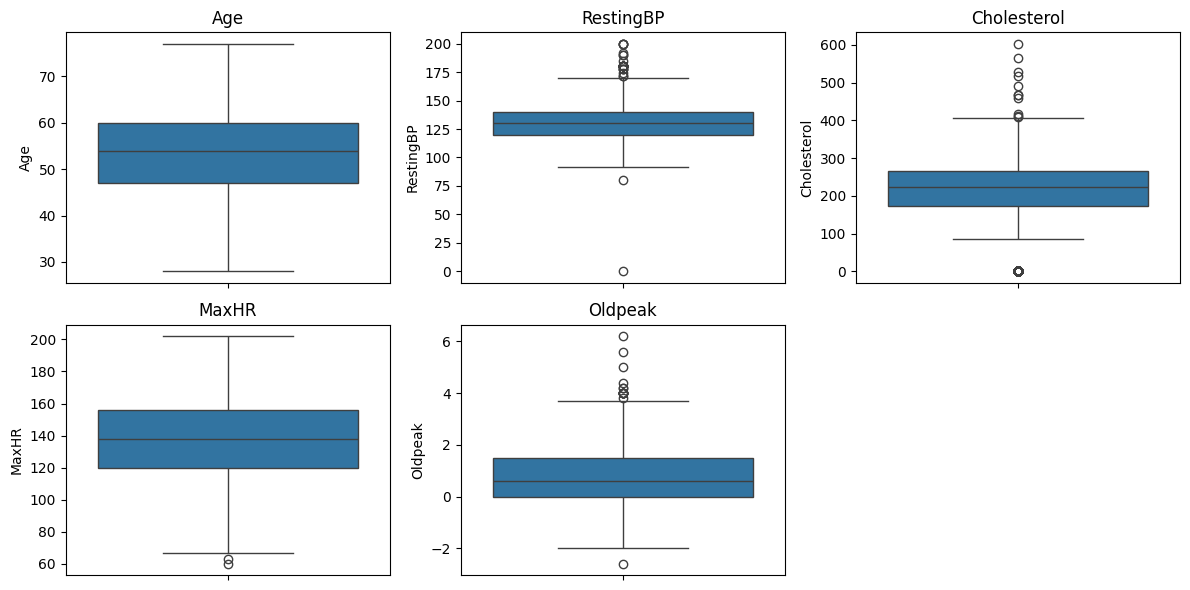

In [8]:
# Set up a grid of boxplots for numerical columns
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=heart_df, y=col)
    plt.title(col)
plt.tight_layout()
plt.show()

In [9]:
# resting blood presssure seems to be have 0 values which doesn't make sense
# check all values for resting BP and if 0 only appears then it might mean
# that the BP was not recorded.

np.sort(heart_df['RestingBP'].unique())

# based on results, the resting BP ranges are normal between 80 and 200 so 0 means
# that the restingBP is not recorder

array([  0,  80,  92,  94,  95,  96,  98, 100, 101, 102, 104, 105, 106,
       108, 110, 112, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 152, 154,
       155, 156, 158, 160, 164, 165, 170, 172, 174, 178, 180, 185, 190,
       192, 200], dtype=int64)

In [10]:
# it seems only one patient has a value with 0 BP
heart_df[heart_df['RestingBP'] == 0]['RestingBP'].count()

1

In [11]:
# since it is only one row let's remove it
heart_df = heart_df[heart_df['RestingBP'] > 0]

In [23]:
# check for any missing values
heart_df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [26]:
# check label distrubtion
heart_df['HeartDisease'].value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

## Preprocessing

Create a copy of the heart dataset for preprocessing

In [91]:
heart_dm = heart_df.copy()

In [92]:
heart_dm

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Let's convert all non-numeric values into numeric values for our ML models

In [15]:
string_columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

In [16]:
# encode all string columns
for str_col in string_columns:
    heart_dm[f'{str_col}_enc'] = LabelEncoder().fit_transform(heart_dm[str_col])

In [17]:
heart_dm.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_enc,ChestPainType_enc,RestingECG_enc,ExerciseAngina_enc,ST_Slope_enc
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,1,1,0,2
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,2,1,0,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,1,2,0,2
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,0,1,1,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,2,1,0,2


In [18]:
encodings = pd.DataFrame()

In [19]:
# encode all string columns
for str_col in string_columns:
    encodings[str_col] = heart_dm[str_col]
    encodings[f'{str_col}_enc'] = heart_dm[f'{str_col}_enc']

In [20]:
encodings.head()

,Sex,Sex_enc,ChestPainType,ChestPainType_enc,RestingECG,RestingECG_enc,ExerciseAngina,ExerciseAngina_enc,ST_Slope,ST_Slope_enc
0,M,1,ATA,1,Normal,1,N,0,Up,2
1,F,0,NAP,2,Normal,1,N,0,Flat,1
2,M,1,ATA,1,ST,2,N,0,Up,2
3,F,0,ASY,0,Normal,1,Y,1,Flat,1
4,M,1,NAP,2,Normal,1,N,0,Up,2


In [21]:
# remove strings from preprocessed dataset
for str_col in string_columns:
    heart_dm[str_col] = heart_dm[f'{str_col}_enc']
    heart_dm.drop(columns=f'{str_col}_enc',inplace=True)

In [22]:
heart_dm

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


## Modeling

The basline ML model will be Logistic Regression and it will be tested against Random Forest

In [39]:
heart_X = heart_dm.drop('HeartDisease',axis=1)

In [40]:
heart_y = heart_dm['HeartDisease']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    heart_X,heart_y, test_size=0.2, random_state=17, stratify=heart_y
)

### Logistic Regression

In [81]:
lr = LogisticRegression(max_iter=1000, random_state=17)

In [82]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=17)

In [83]:
# predictions
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

**Key Metrics:**

- Precision/Recall/F1-score: Focus on the minority class (0).

- ROC-AUC: Measures overall class separation (closer to 1 = better).

In [84]:
# evaluate
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        82
           1       0.82      0.91      0.87       102

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.84       184
weighted avg       0.85      0.84      0.84       184

ROC-AUC: 0.8998


### Random Forest

In [85]:
rf = RandomForestClassifier(random_state=17)

In [86]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [87]:
# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [88]:
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")


Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        82
           1       0.85      0.97      0.91       102

    accuracy                           0.89       184
   macro avg       0.90      0.88      0.89       184
weighted avg       0.90      0.89      0.89       184

ROC-AUC: 0.9145


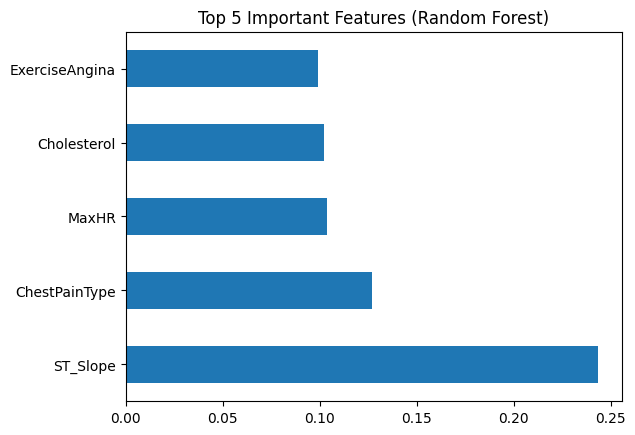

In [89]:
# Plot top 5 important features
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importance.nlargest(5).plot(kind='barh')
plt.title("Top 5 Important Features (Random Forest)")
plt.show()

### Validation

Let's do a quick cross value validation

In [90]:
# Logistic Regression AUC (CV)
lr_auc = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5, scoring='roc_auc').mean()

# Random Forest AUC (CV)
rf_auc = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5, scoring='roc_auc').mean()

print(f"Logistic Regression AUC (CV): {lr_auc:.4f}")
print(f"Random Forest AUC (CV): {rf_auc:.4f}")

Logistic Regression AUC (CV): 0.9143
Random Forest AUC (CV): 0.9345


**Final Verdict**: the Random Forest classifier seems to be a better fit for the heart disease
predictions and therefore it will be selected to be deployed and utilized

## Deployment